# **Avance 2. Series de tiempo univariadas**
## **Universidad Nacional de Colombia**

---

### **Docente:**

  - [Sergio Alejandro Calderón Villanueva](sacalderonv@unal.edu.co)

### **Autores:**

  - [Michel Mendivenson Barragán Zabala](mbarraganz@unal.edu.co)
  - [Sharon Juliana Zambrano Ortiz](shzambranoo@unal.edu.co)
  - [Nicolás Alejandro Quenguan Parra](naquenguanp@unal.edu.co)
  - [Aryin Jair Torres Quiñone](artorresq@unal.edu.co)

---

# **Preámbulo**

---

A continuación se explorar a partir de lo hallado en el [avance 1](https://rpubs.com/Mendivenson/Avance1_STdU) la aplicación de filtros exponencials, árboles de decisión y redes neuronales multicapa y recurrentes para la predicción de las series de tiempo cuya información puede ser encontrada a continuación:

- [Acopio mensual de leche en el país de 2008 a 2023](http://uspleche.minagricultura.gov.co/documentos.html)
- [Precio de venta del oro en el país a partir de 2004](https://www.banrep.gov.co/es/estadisticas/precios-del-dia-para-el-gramo-oro-plata-y-platino)

En adición a esto y a la aplicación de las herramientas ya utilizadas en clase, se utilizará código de `R` junto con código de `python` con la finalidad exclusiva de reutilizar código realizado en el avance 1.  Para este fin, se utiliza el paquete `rpy2`pues desde un entorno de `jupyter` este permite pasar obetos de un entorno de `R` a `python` y viceversa.

## **Paquetes necesarios por sección**

A continuación se hace una discriminación por secciones para los paquetes necesarios. Y una configuración inicial del paquete `rpy2`.

Cuando se está trabajando en *Google Colaboratoy* se deben correr las siguientes celdas para instalar `rpy2` y `skforecast` antes de usarlos:

In [ ]:
# !pip install skforecast
# !pip install rpy2

En caso contrario, se pueden correr desde el terminal los comandos sin el prefijo `!` para instalar los paquetes.

In [1]:
%load_ext rpy2.ipython

Respecto al paquete `rpy2` lo único necesario para correr código `R` es usar como inicio de cada celda `%%R -o <Objeto que sale de R y entra a python>` o `%%R -i <Objeto que sale de python y entra a R>` aunque evidentemente, no es necesario siempre enviar un objeto de salida o de entrada.

### **Filtro exponencial**

### **Árboles de decisión**

Es posible que deba hacerse la instalación usando `%%R install.packages(<paquete>)` de algunos paquetes

In [87]:
%%R
library(latex2exp)
library(astsa)
library(dplyr)
library(MASS)


Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select



In [76]:
import pandas as pd
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.tree import DecisionTreeRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import pandas as pd
import matplotlib.pylab as plt
from sklearn import tree
import numpy as np
import scipy as sp
import scipy.stats
import os

### **Redes neuronales multicapa**

### **Redes neuronales recurrentes**

# **Filtro exponencial**

# **Árboles de decisión**

---

Los árboles de decisión son herramientas importantes para la predicción en series de tiempo debido a la sencillez de su implementación. Sin embargo, no son muy buenos manejando series que presenten aún tendencia por lo cual para cada serie debería de eliminarse la tendencia antes de usar este método.

## **Acopio nacional de leche** 🐮

Esta serie, como se evidenció en el avance anterior, parece demostrar una tendencia positiva en relación con el tiempo y una estacionariedad de al parecer un año. Por lo que inicialmente debemos eliminar la tendencia para poder generar un árbol de decisión. A continuación un breve listado de lo que se hace en esta sección:

- Lectura de datos
- Eliminación de tendencia
- Selección de rezagos
- Datos de entrenamiento y prueba
- Árboles de decisión:
    - Usando solamente rezagos
    - Usando rezagos y información exógena para la componente estacional
    - Busquéda de hierparámetros con backtesting
    - Para serie con tendencia
    - Comparación de resultados entre serie con tendencia y serie sin tendencia

Ademaś de esto, cabe destacar que esta serie contiene apenas 192 registros por lo que para la búsqueda de hiperparámetros para cada uno de los árboles se usará validación cruzada. Finalmente, respecto a la varianza de la serie, en el avance 1 se vió que la transformación de los datos no es necesaria por lo que se usa la serie original.

### **Lectura de datos**

Como se mencionó inicialmente, se utilizará el código realizado en el avance 1.

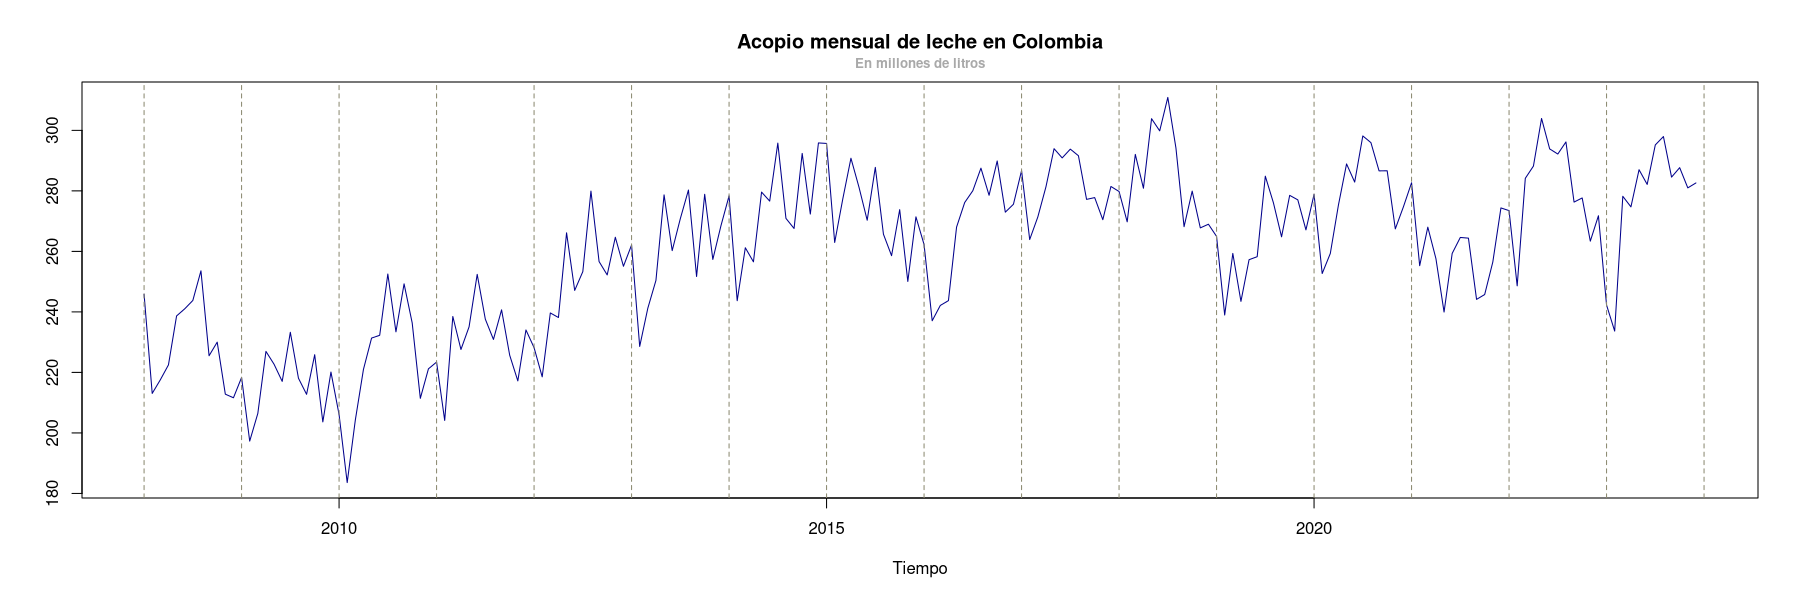

In [15]:
%%R -w 18 -h 6 --units in -r 100
# -w 18 -h 6 --units in -r 100 Ajusta el ancho y alto de la ventana 

leche = read.csv("https://raw.githubusercontent.com/Mendivenson/Series-de-tiempo/main/Datos/Volumen%20de%20Acopio%20Total%20%20(2008%20-%202023).csv")

# Datos a los que se les quitará la tendencia
leche = leche[, c('Periodo', 'NACIONAL')]
leche$NACIONAL = leche$NACIONAL/1000000

# Datos a los que no se les quitará la tendencia
lecheTend = leche

# Secuencia temporal de la serie
tiempo = seq(2008,2023.99, by = 1/12)

# Gráfico de la serie
plot(x = tiempo ,y = leche$NACIONAL, xlab = 'Tiempo', ylab = '', 
     main = 'Acopio mensual de leche en Colombia',col = 'darkblue', cex = 0.5, type = 'l')
mtext(bquote(bold('En millones de litros')), side = 3, line = 0.5, adj = 0.5, cex = 0.8, col = 'darkgray')
abline(v = 2008:2024, lty = 'dashed', pch = 2, col = '#8B8970')

### **Eliminación de la tendencia**

Se elimina la tendencia de la serie usando un suavizado kernel

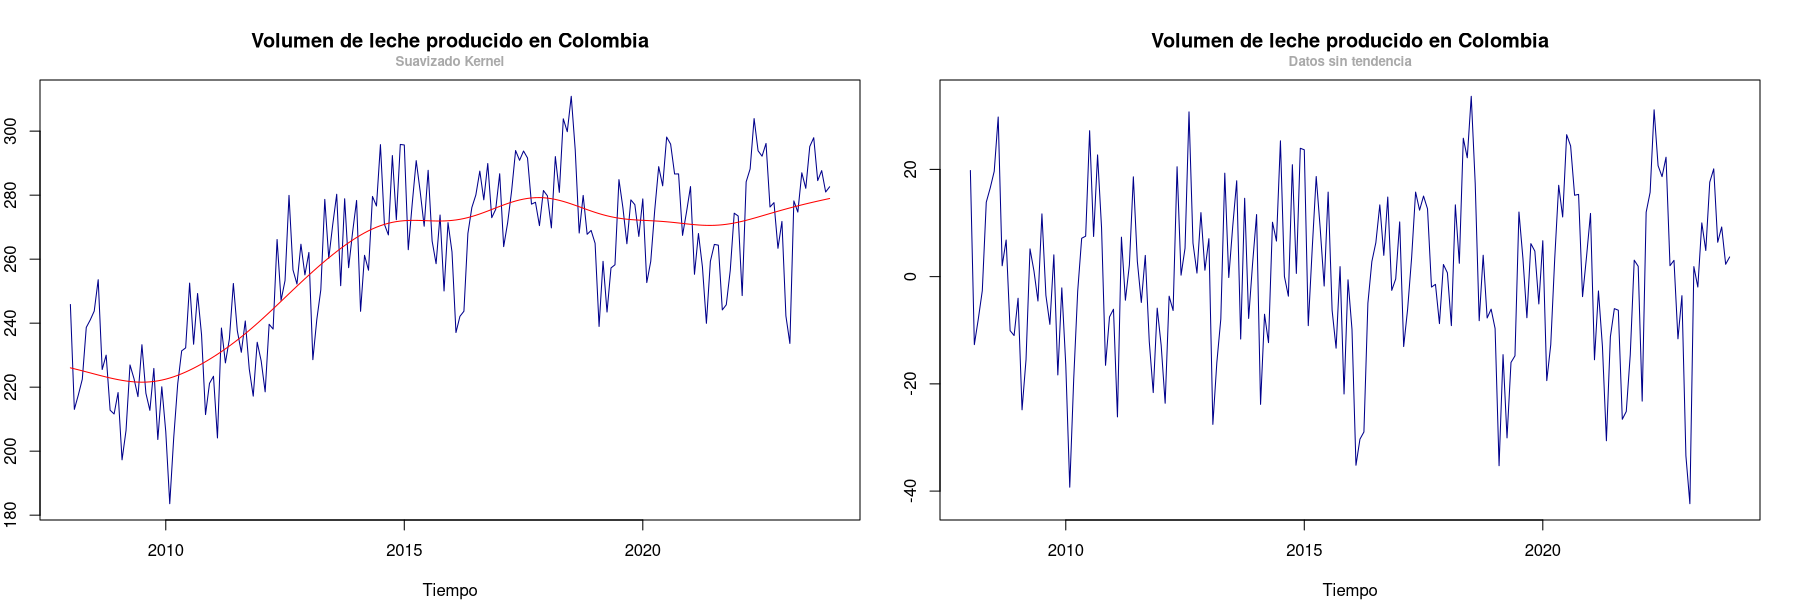

In [17]:
%%R -o leche -w 18 -h 6 --units in -r 100

predicciones = ksmooth(y = leche$NACIONAL, x = tiempo, kernel = 'normal', bandwidth = 2.5)$y

# === GRÁFICO ===
par(mfrow = c(1,2),
   mar = c(4,2,4,2))

# Original y suavizamiento kernel
plot(x = tiempo ,y = leche$NACIONAL, xlab = 'Tiempo', ylab = '', main = 'Volumen de leche producido en Colombia',col = 'darkblue', cex = 0.5, type = 'l')
mtext(bquote(bold('Suavizado Kernel')), side = 3, line = 0.5, adj = 0.5, cex = 0.8, col = 'darkgray')
lines(x = tiempo,y = predicciones, col = 'red')

# Eliminando la tendencia
leche$NACIONAL = leche$NACIONAL - predicciones

# Datos sin tendencia
plot(x = tiempo,y = leche$NACIONAL,xlab = 'Tiempo', ylab = '', main = 'Volumen de leche producido en Colombia',col = 'darkblue', cex = 0.5, type = 'l')
mtext(bquote(bold('Datos sin tendencia')), side = 3, line = 0.5, adj = 0.5, cex = 0.8, col = 'darkgray')

# Actualizando el dataframe para devolverlo a python:
colnames(leche) = c('Date', 'Volume')

### **Selección de rezagos**

A continuación, se presenta algunas gráficas que serán de utilidad para determinar que rezagos deberíamos tener en cuenta a la hora de construir un árbol de decisió;

- Autocorrelación y autocorrelación parcial
- Gráfico de subseries y boxplot por meses
- Periodograma
- Gráfico de retardos

#### **Autocorrelación y autocorrelación parcial**

La autocorrelación y autocorrelación parcial sugieren relación del valor de la serie en el tiempo actual con el rezago 12. Es decir, una estacionalidad anual.

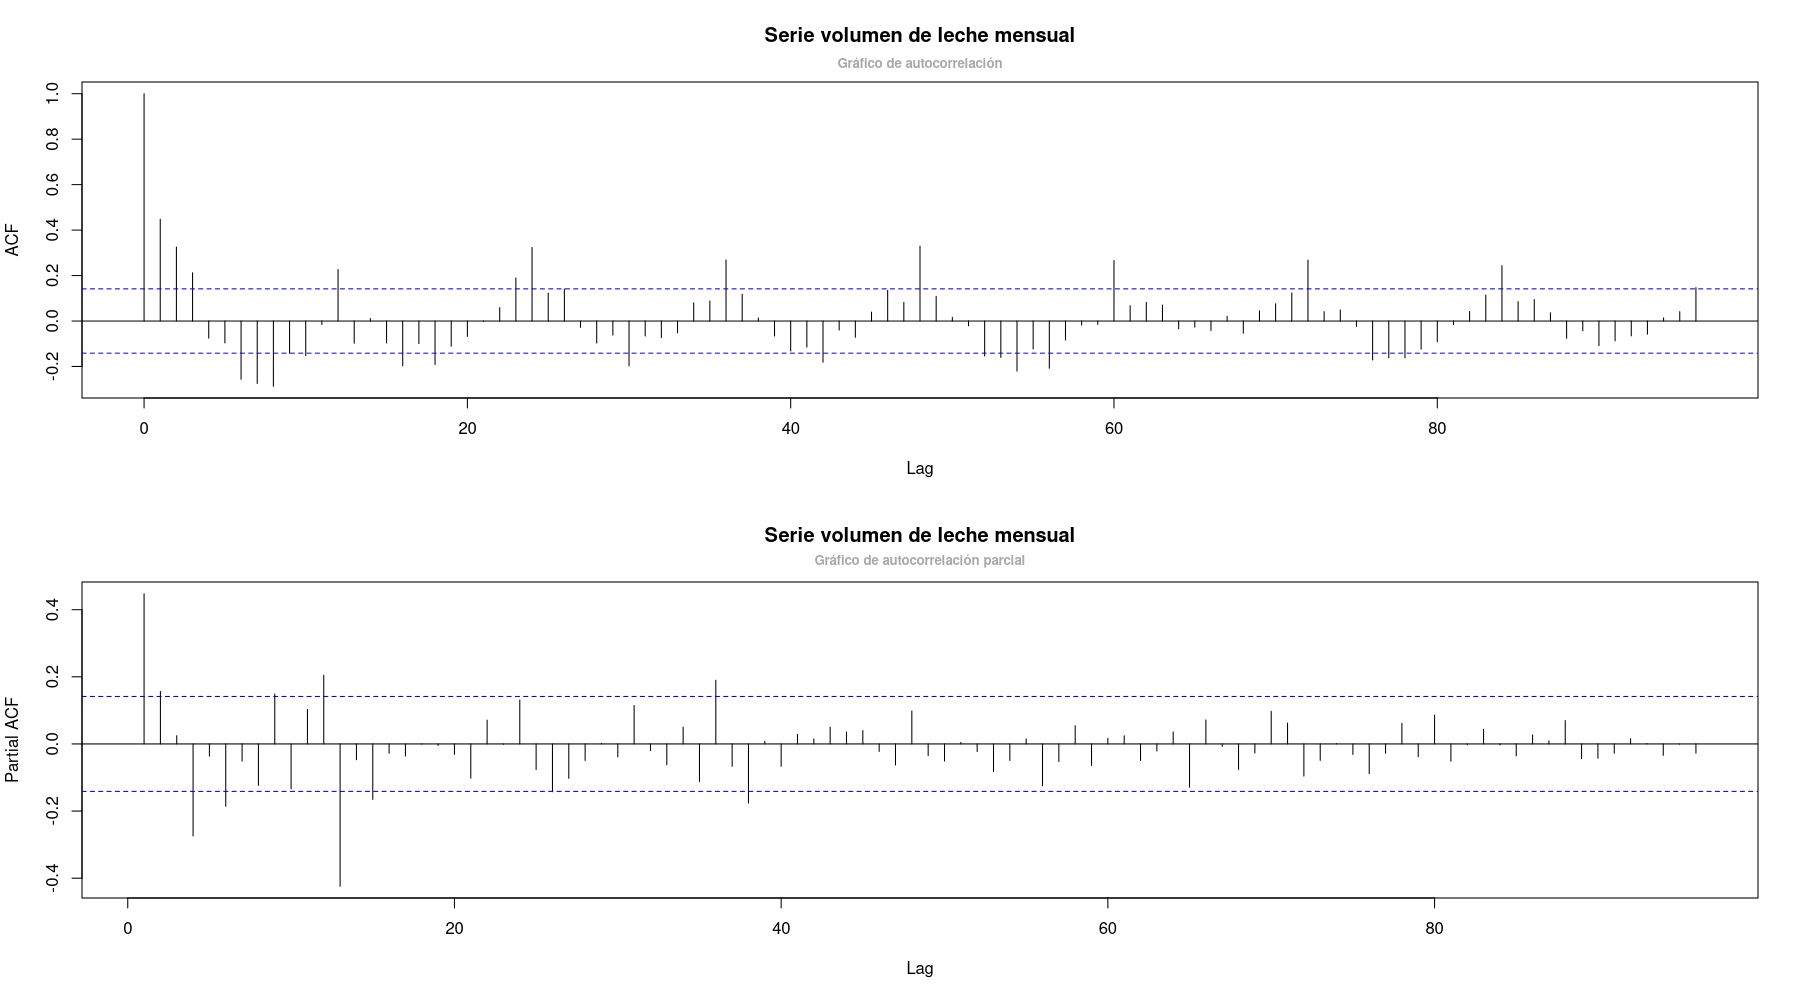

In [19]:
%%R -w 18 -h 10 --units in -r 100
par(mfrow = c(2,1))

# Autocorrelación
acf(leche$Volume, lag.max = 96, main = 'Serie volumen de leche mensual')
mtext(bquote(bold('Gráfico de autocorrelación')), side = 3, line = 0.5, adj = 0.5, cex = 0.8, col = 'darkgray')

# Autocorrelación parcial
pacf(leche$Volume, lag.max = 96, main = 'Serie volumen de leche mensual')
mtext(bquote(bold('Gráfico de autocorrelación parcial')), side = 3, line = 0.5, adj = 0.5, cex = 0.8, col = 'darkgray')

#### **Boxplot y subseries mensuales**

Parece ser claro que existen diferencias entre las medias de la serie respecto a cada mes.

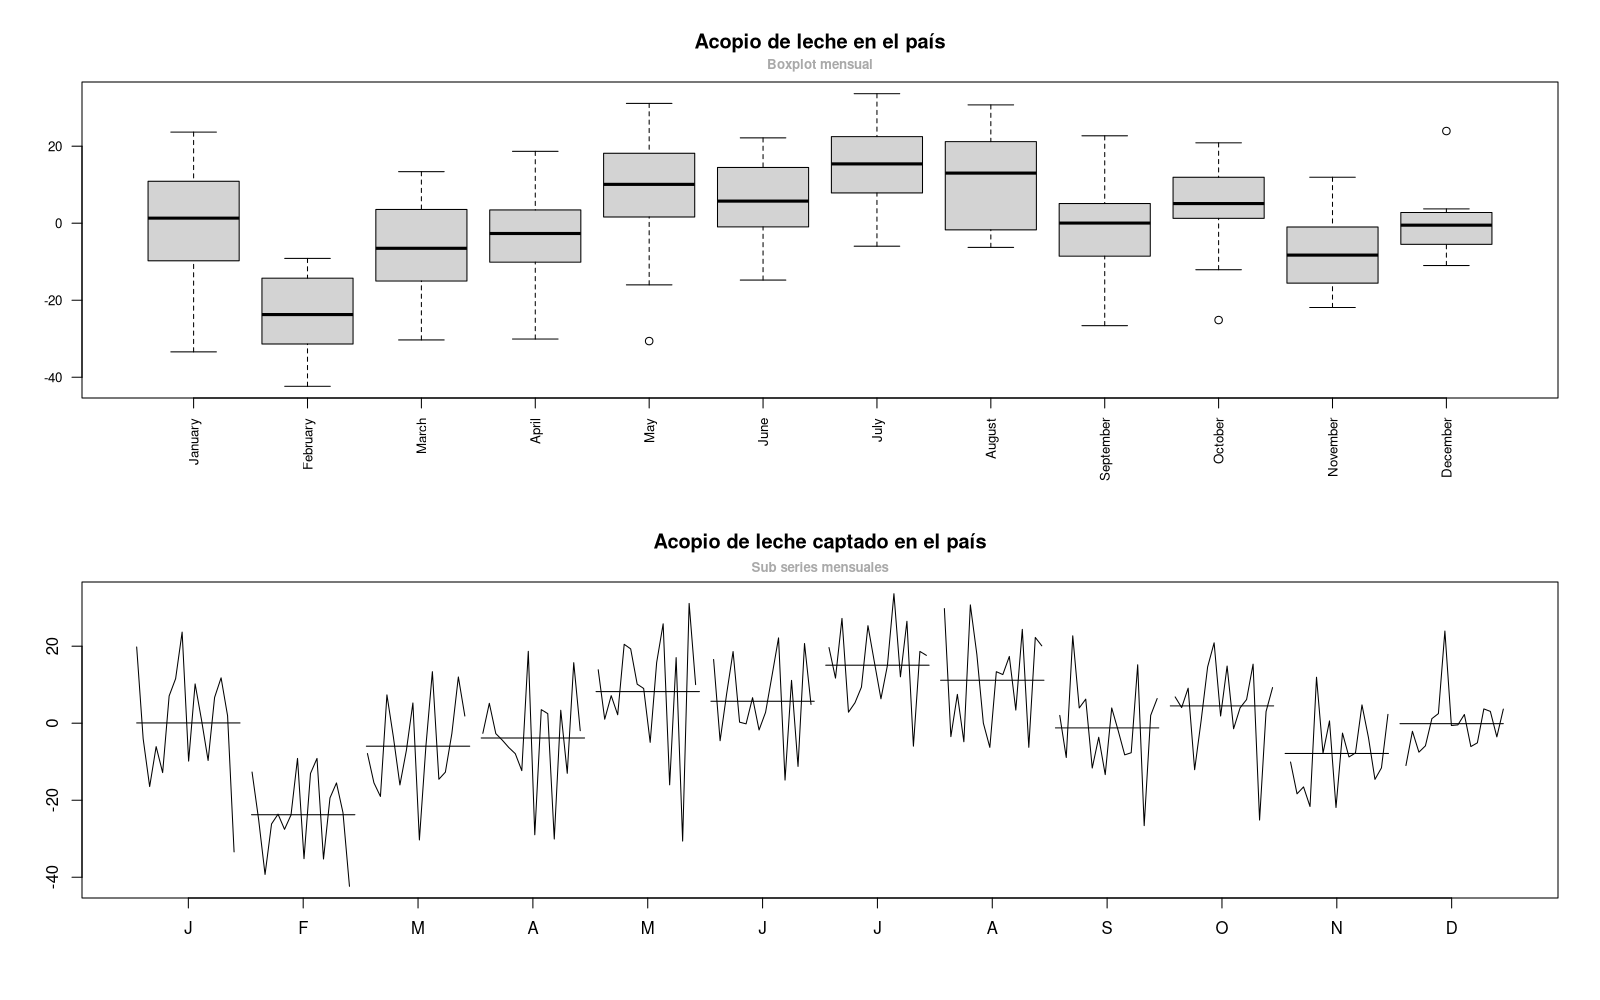

In [21]:
%%R -w 16 -h 10 --units in -r 100

SerieLeche = ts(leche$Volume, start = 2008, frequency = 12)

# Esta parte se puede hacer más rápido xd
months = 1:nrow(leche) %% 12
months[months == 0] = 12
leche$Month = month.name[months]

lechePorMeses = data.frame(row.names = month.name[1:12])
for (i in month.name[1:12]){
    lechePorMeses[i,1:16] = leche$Volume[leche$Month == i]
}

lechePorMeses = t(lechePorMeses)
rownames(lechePorMeses) = 2008:2023

par(mfrow = c(2,1))

# Gráfico de boxplot por meses
boxplot(lechePorMeses,las = 2, cex.axis = 0.8, main = 'Acopio de leche en el país')
mtext(bquote(bold('Boxplot mensual')),
      side = 3, line = 0.3, adj = 0.5, cex = 0.8, col = 'darkgray')

# sub series mensuales
monthplot(SerieLeche, ylab = '', main = 'Acopio de leche captado en el país')
mtext(bquote(bold('Sub series mensuales')),
      side = 3, line = 0.3, adj = 0.5, cex = 0.8, col = 'darkgray')

#### **Periodograma**

Revisemos si además de la importancia de los rezagos anuales encontramos otros rezagos importantes usando el periodograma. Donde no se encuentran más rezagos significativos

				 ---- LOS PRIMEROS TRES VALORES MÁXIMOS ----  

-	El valor máximo no. 1  en el que se máximiza el periodograma es 4488.692 en la frecuencia  0.08333333 
 	o lo que es equivalente a  1 años 
-	El valor máximo no. 2  en el que se máximiza el periodograma es 1798.497 en la frecuencia  0.04166667 
 	o lo que es equivalente a  0.5 años 
-	El valor máximo no. 3  en el que se máximiza el periodograma es 1420.426 en la frecuencia  0.4166667 
 	o lo que es equivalente a  5 años 






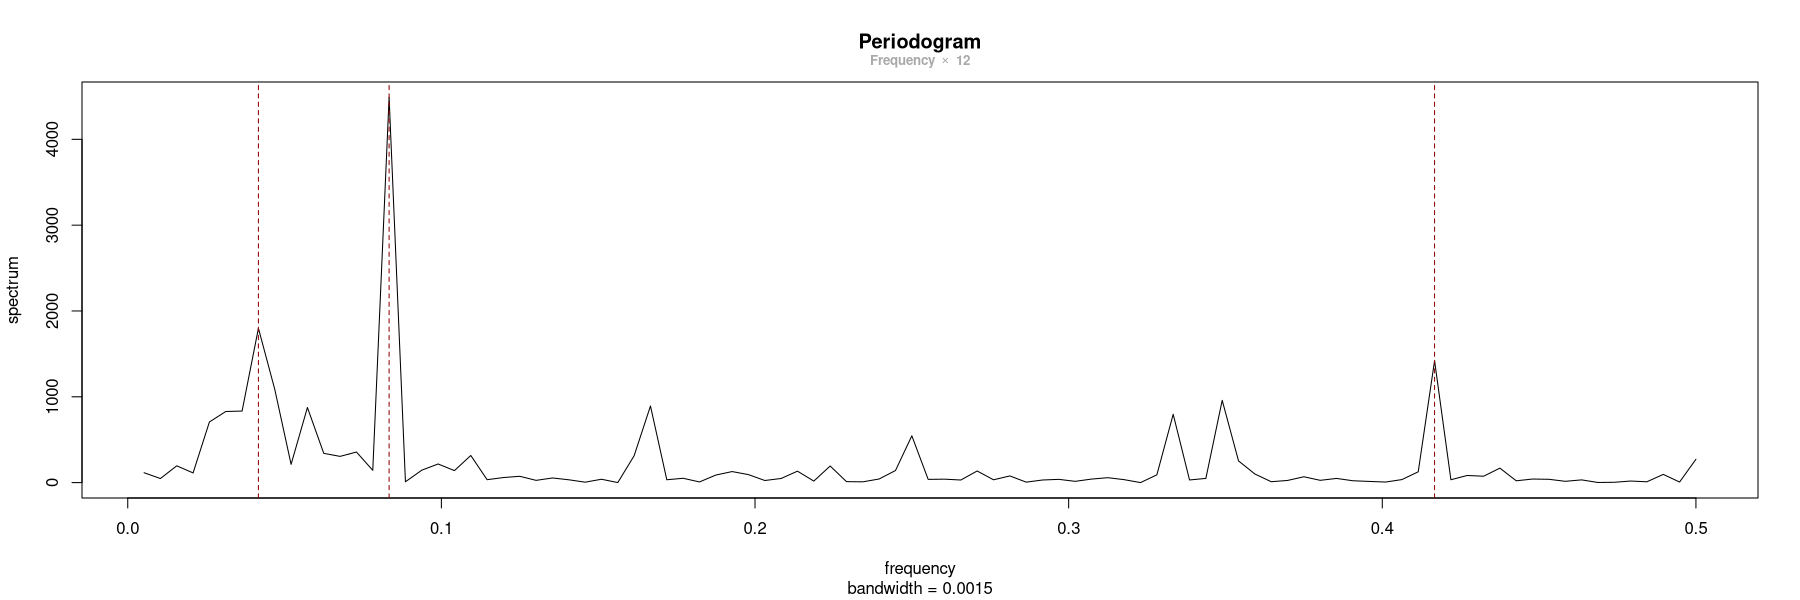

In [26]:
%%R -w 18 -h 6 --units in -r 100
PeriodogramaLeche = spectrum(leche$Volume, log = 'no', main = 'Periodogram')
mtext(TeX('Frequency $\\times$ 12', bold = T),
      side = 3, line = 0.5, adj = 0.5, cex = 0.8, col = 'darkgray')

Periodograma = PeriodogramaLeche$spec
frecuencias = PeriodogramaLeche$freq

cat('\t\t\t\t ---- LOS PRIMEROS TRES VALORES MÁXIMOS ---- ', end = '\n\n')
for (i in 1:3){
  ind = which.max(Periodograma)
  cat('-\tEl valor máximo no.', i, ' en el que se máximiza el periodograma es', Periodograma[ind], 'en la frecuencia ',
      frecuencias[ind],'\n \to lo que es equivalente a ',   frecuencias[ind] * 12 , 'años', end = '\n')
  abline(v = frecuencias[ind], col = 'darkred', lty = 2)
  Periodograma = Periodograma[-ind]
  frecuencias = frecuencias[-ind]
}

cat('\n\n\n\n')

#### **Gráfico de retardos**

Parece ser que además del rezago 12, el rezago 1, 2, 3 y 6 tienen relación con el valor actual de la serie (Aunque no estrictamente lineal)

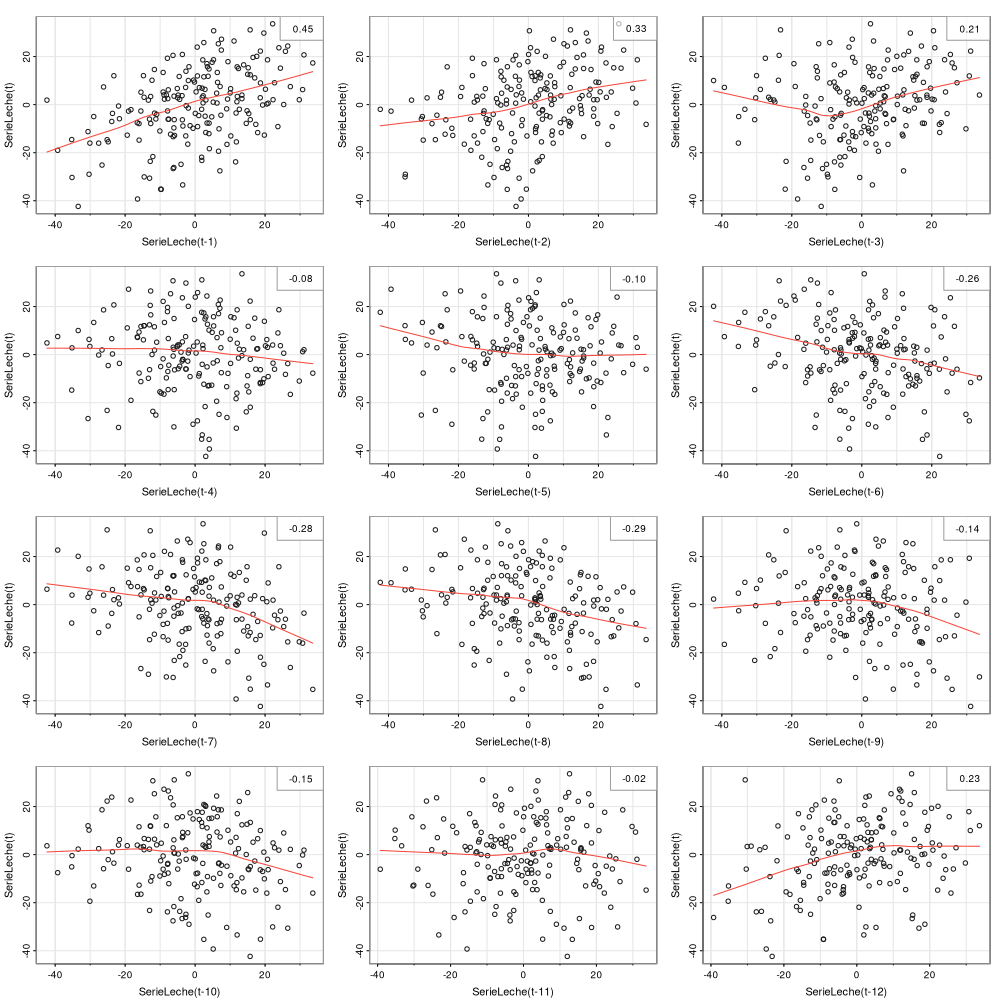

In [27]:
%%R -w 10 -h 10 --units in -r 100
astsa::lag1.plot(SerieLeche, 12,corr = T)

### **Datos de entrenamiento y prueba**

Como se mencionó anteriormente, es una serie pequeña por lo que no se utilizarán los datos de validación y se usará solamente el último año como datos de prueba. Recuerde que el objeto `leche` ya fue pasado antes como dataframe a `python`

In [35]:
leche

,Date,Volume
1,2008-01-01,19.795864
2,2008-02-01,-12.682066
3,2008-03-01,-7.872412
4,2008-04-01,-2.623688
5,2008-05-01,13.881874
...,...,...
188,2023-08-01,20.100389
189,2023-09-01,6.408911
190,2023-10-01,9.259564
191,2023-11-01,2.303314


Para poder manejar correctamente los datos en necesario cambiar la columna `Date` a formato de fecha, pues si no es formato de fecha en cuanto intentemos usar esta columna como index borrará los datos de la columna `Volume`

In [36]:
# Cambiar a tipo de dato fecha
leche['Date'] = pd.to_datetime(leche2['Date'],format='%b-%y')

# Establecer a Date como indíce
leche = leche.set_index('Date')

# Fijar la regularidad de los datos como mensual
leche = leche.asfreq('MS')

leche

,Volume
Date,
2008-01-01,19.795864
2008-02-01,-12.682066
2008-03-01,-7.872412
2008-04-01,-2.623688
2008-05-01,13.881874
...,...
2023-08-01,20.100389
2023-09-01,6.408911
2023-10-01,9.259564


Y ahora sí podemos dividir los datos entre entrenamiento y prueba:

In [37]:
trainLeche = leche['Volume'][0:-12]
trainLeche

Date
2008-01-01    19.795864
2008-02-01   -12.682066
2008-03-01    -7.872412
2008-04-01    -2.623688
2008-05-01    13.881874
                ...    
2022-08-01    22.273918
2022-09-01     2.036131
2022-10-01     3.040229
2022-11-01   -11.597113
2022-12-01    -3.549744
Freq: MS, Name: Volume, Length: 180, dtype: float64

In [38]:
testLeche = leche['Volume'][-12:len(leche)]
testLeche

Date
2023-01-01   -33.413477
2023-02-01   -42.349878
2023-03-01     1.871824
2023-04-01    -1.942573
2023-05-01    10.025542
2023-06-01     4.868121
2023-07-01    17.619143
2023-08-01    20.100389
2023-09-01     6.408911
2023-10-01     9.259564
2023-11-01     2.303314
2023-12-01     3.667490
Freq: MS, Name: Volume, dtype: float64

Es decir, nuestra serie queda dividida así:

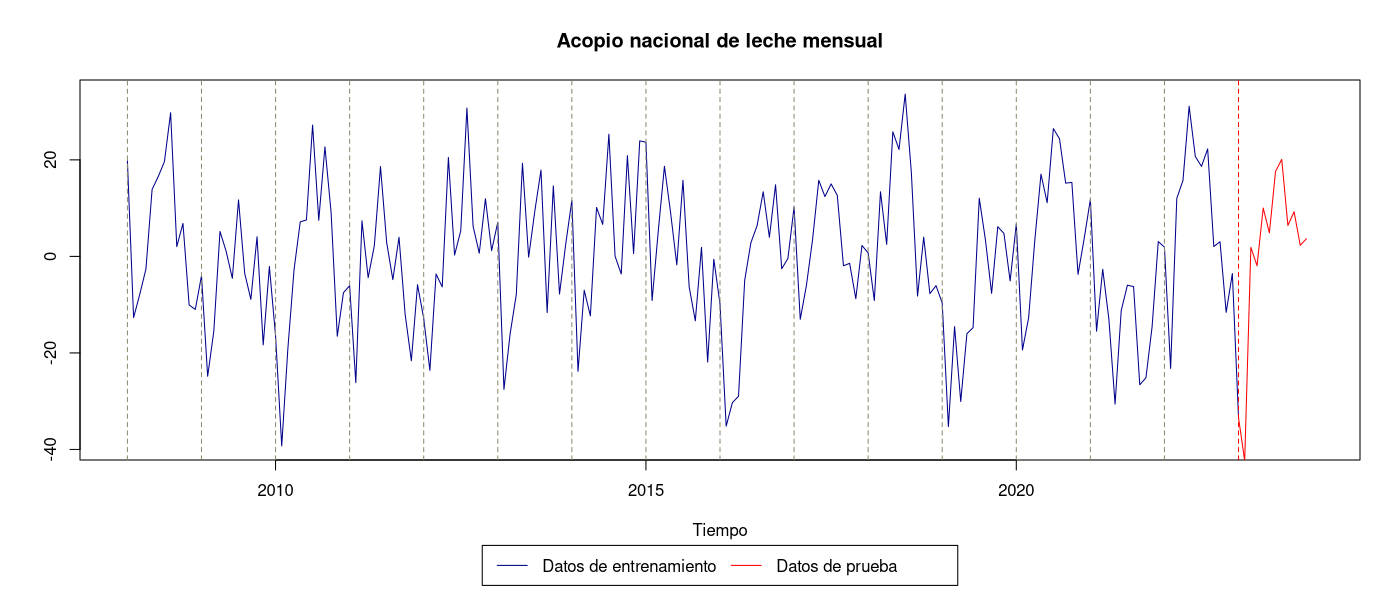

In [40]:
%%R -w 14 -h 6 --units in -r 100
par(mar = c(7,4,4,2))
plot(x = seq(2008, 2023, by= 1/12), y = head(leche$Volume, n = nrow(leche)-11), type = 'l',
     main = 'Acopio nacional de leche mensual', ylab = '', xlab = 'Tiempo', col = 'darkblue', xlim = c(2008,2024))
abline(v = 2008:2023, lty = 'dashed', pch = 2,col = c(rep('#8B8970', 15), 'red'))
lines(x = seq(2023, 2023.99, by = 1/12), y = tail(leche$Volume, n = 12),
      col = 'red')
legend(inset = c(0,-0.33),'bottom',col = c('darkblue', 'red'), lty = 'solid',
       legend = c('Datos de entrenamiento', 'Datos de prueba'), xpd = T, horiz = T)

### **Árboles de decisión**

Como se mencionó anteriormente, se seleccionan varios métodos para generar varios árboles y quedarnos con el de mejor desempeño

#### **Utilizando solamente los rezagos como variables adicionales**

Se utilizarán varios rezagos teniendo en cuenta lo que se dijo en la sección de selección de rezagos para encontrar los hiperparámetros del árbol que hagan que este tenga un mejor desempeño. Se usarán los rezagos:

- Del 1 al 12
- 1, 2, 3, 6, 12,
- 1 y múltiplos de 3 hasta llegar al rezago 12
- 1 y 12
- 6 y 12

In [71]:
# Árbol
arbolLeche = ForecasterAutoreg(
    regressor = DecisionTreeRegressor(),
    lags = 2
)

# Rezagos a probar en grid search
rezagos = [1,2,3,4,5,6,7,8,9,10,11,12,
          [1,2,3,6,12],
          [1,3,6,9,12],
          [1,12],
          [6,12]]

# Pasos hacia delante en los que se desea hacer la predicción 
pasos = 12

# Profundidad máxima para la que se probará el árbol
parámetros = {'max_depth': list(range(1,30))}

Y finalmente, realizamos la búsqueda de los mejores hiperparámetros:

In [72]:
grid_search_leche = grid_search_forecaster(
                        forecaster         = arbolLeche,
                        y                  = trainLeche,
                        param_grid         = parámetros,
                        lags_grid          = rezagos,
                        steps              = pasos,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(trainLeche)*0.25),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 464.


lags grid:   0%|          | 0/16 [00:00<?, ?it/s]

params grid:   0%|          | 0/29 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2] 
  Parameters: {'max_depth': 3}
  Backtesting metric: 229.2129830643904



In [73]:
grid_search_leche

,lags,params,mean_squared_error,max_depth
31,"[1, 2]",{'max_depth': 3},229.212983,3
290,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]",{'max_depth': 1},232.449803,1
203,"[1, 2, 3, 4, 5, 6, 7, 8]",{'max_depth': 1},232.785273,1
232,"[1, 2, 3, 4, 5, 6, 7, 8, 9]",{'max_depth': 1},232.883382,1
261,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'max_depth': 1},233.459230,1
...,...,...,...,...
16,[1],{'max_depth': 17},512.595576,17
24,[1],{'max_depth': 25},512.595576,25
85,"[1, 2, 3]",{'max_depth': 28},513.125415,28
270,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'max_depth': 10},532.476242,10


Se probará el impacto del tamaño de muestra inicial en el rendimiento del árbol:

In [74]:
grid_search_leche = grid_search_forecaster(
                        forecaster         = arbolLeche,
                        y                  = trainLeche,
                        param_grid         = parámetros,
                        lags_grid          = rezagos,
                        steps              = pasos,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(trainLeche)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 464.


lags grid:   0%|          | 0/16 [00:00<?, ?it/s]

params grid:   0%|          | 0/29 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'max_depth': 1}
  Backtesting metric: 220.70943598386808



In [75]:
grid_search_leche

,lags,params,mean_squared_error,max_depth
174,"[1, 2, 3, 4, 5, 6, 7]",{'max_depth': 1},220.709436,1
290,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]",{'max_depth': 1},237.108682,1
175,"[1, 2, 3, 4, 5, 6, 7]",{'max_depth': 2},241.702636,2
0,[1],{'max_depth': 1},251.859165,1
261,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'max_depth': 1},253.180950,1
...,...,...,...,...
311,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]",{'max_depth': 22},664.905590,22
273,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'max_depth': 13},670.256092,13
301,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]",{'max_depth': 12},674.729826,12
286,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'max_depth': 26},677.123716,26


#### **Usando infrormación exógena**

Se agregan componentes de Fourier para representar la estacionalidad anual de la serie.

#### **Buscando los hiperparámetros con backtesting**

Se utiliza ahora backtesting para revisar si es posible generar un mejor modelo.

#### **Árbol de decisión para la serie con tendencia**

Efectivamente los árboles de decisión son muy imprecisos cuando se trata de series con tendencia.

#### **Comparación de resultados y predicción con el modelo final**

## **Precio de venta del oro en Colombia** 🪙

Nuevamente, ateniendonos lo que se expuso en el avance anterior, esta serie presenta tendencia que necesitamos eliminar antes de generar nuestro árbol de decisión. En esta sección podrá encontrarse con:

- Lectura de datos
- Eliminación de la tendencia y estabilización de la varianza
- Autocorrelación y autocorrelación parcial
- Datos de entrenamiento y prueba
- Árboles de decisión:
    - Para la serie diferenciada
    - Para la serie con tendencia
    - Manualmente
    - Bosque aleatorio
- ¿Modelo final?

### Lectura de datos

Se usa nuevamente el código de `R` presentado en el avance 1

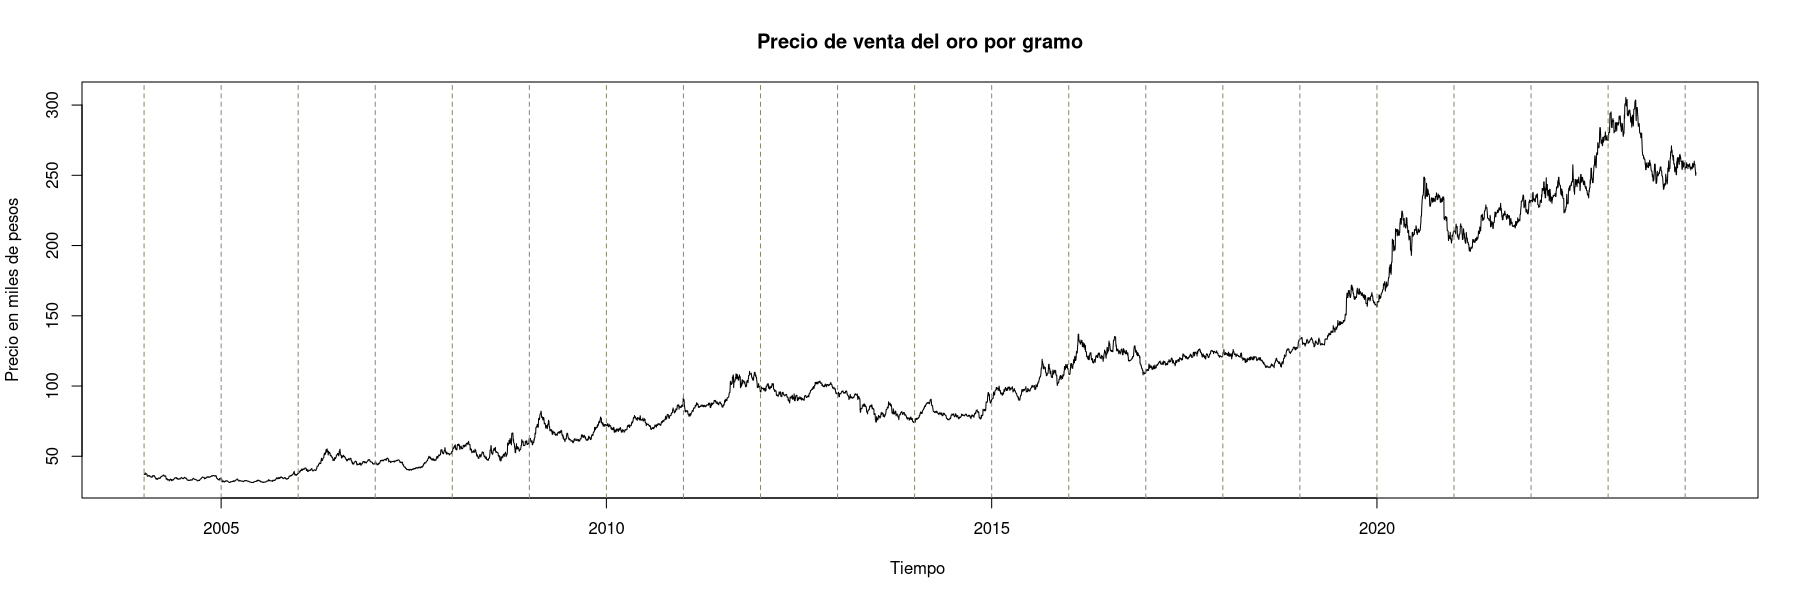

In [201]:
%%R -w 18 -h 6 --units in -r 100

# Lectura de los datos
oro <- read.csv(file = 'https://raw.githubusercontent.com/Mendivenson/Series-de-tiempo/main/Datos/Serie%20hist%C3%B3rica%20diaria%20por%20a%C3%B1o%20(1994%20-%202024).csv')


oro <- oro %>% rename(Fecha = Fecha..DD.MM.AAAA.)

# Filtrando por tipo de material y precio de venta
oro <- oro %>%
  dplyr::filter(Metal == "Oro", Métrica == "Precio de Venta") %>%
  dplyr::arrange(Fecha) %>%
  dplyr::select(Fecha, Valor)

# Poniendo formato de fecha a la columna de fecha
# oro$Fecha <- as.Date(oro$Fecha)

# Cambiando los separadores decimales y cambiando a tipo numérico
oro$Valor <- as.numeric(gsub(',','.',oro$Valor))

# Tomamos los datos desde el año 2004 hasta la última fecha
oro <- oro[as.Date(oro$Fecha) >= as.Date('2004-01-01'),]

# Los datos ahora estarán en miles de pesos
oro$Valor = oro$Valor/1000

SerieOro = ts(oro$Valor, start = c(2004,1), frequency = 365)

plot(SerieOro, main = 'Precio de venta del oro por gramo',
    ylab = 'Precio en miles de pesos', xlab = 'Tiempo ')
abline(v = 2004:2024, lty = 'dashed', pch = 2, col = '#8B8970')

### **Estabilización de la varianza**

Al calcular el valor de $\lambda$ para la transformación Box-Cox encontramos que el valor es cercano a cero.

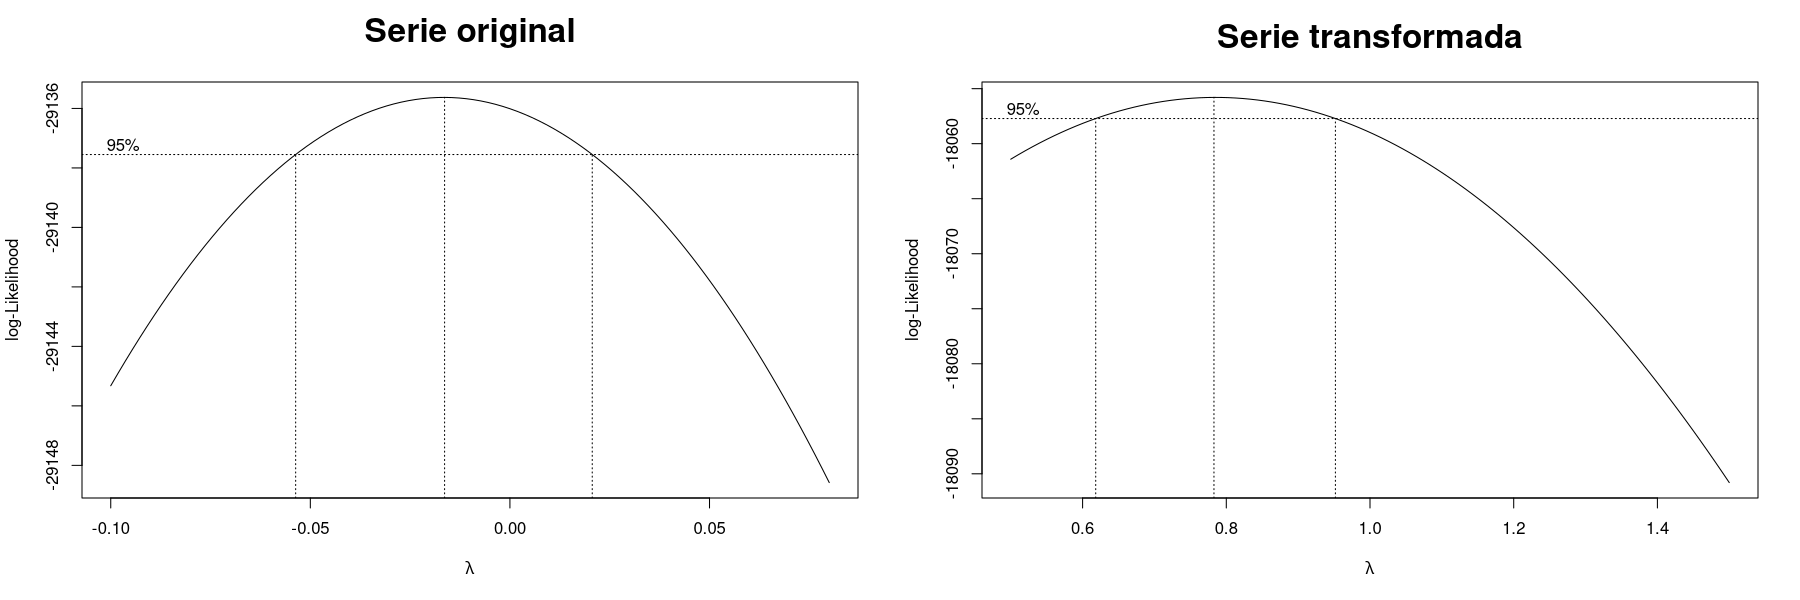

In [202]:
%%R -w 18 -h 6 --units in -r 100

par(mfrow = c(1,2))

MASS::boxcox(lm(SerieOro ~ 1), seq(-0.1,0.08, length = 50))
mtext(expression(bold('Serie original')), side = 3, line = 1.5, cex = 2)

SerieOro = log(SerieOro)
oro$Valor = log(oro$Valor)

MASS::boxcox(lm(SerieOro ~ 1), seq(0.5,1.5, length = 50))
mtext(expression(bold('Serie transformada')), side = 3, line = 1.5, cex = 2)

La serie transformada se ve así:

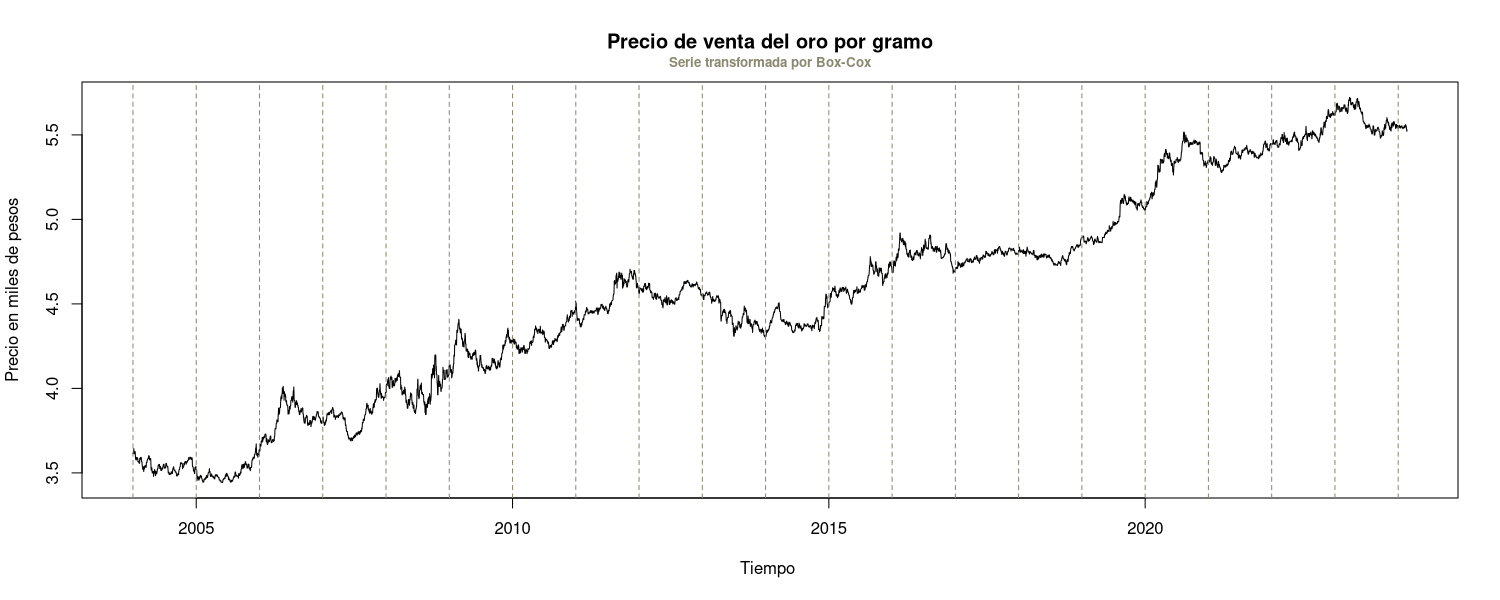

In [203]:
%%R -w 15 -h 6 --units in -r 100
plot(SerieOro, main = 'Precio de venta del oro por gramo',
    ylab = 'Precio en miles de pesos', xlab = 'Tiempo ')
abline(v = 2004:2024, lty = 'dashed', pch = 2, col = '#8B8970')
mtext(expression(bold('Serie transformada por Box-Cox')), side = 3, cex = 0.8, line = 0.4, col = '#8B8970')

### **Eliminación de la tendencia**

Se elimina la tendencia usando diferenciación a 1 rezago.

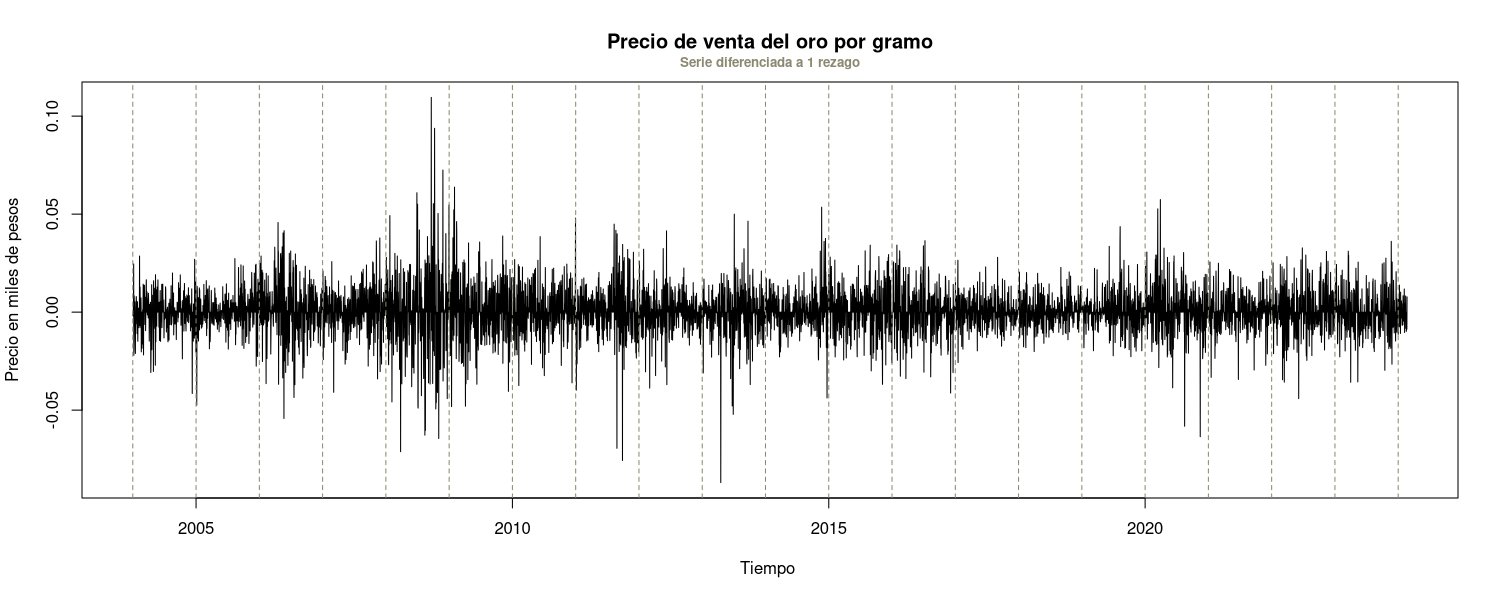

In [204]:
%%R -o oro -w 15 -h 6 --units in -r 100
SerieOro = diff(SerieOro, lag = 1)

# Al diferenciar se pierde el primer valor de la serie
oro = oro[2:nrow(oro),]
oro$Valor = SerieOro

plot(SerieOro, main = 'Precio de venta del oro por gramo',
    ylab = 'Precio en miles de pesos', xlab = 'Tiempo ')
abline(v = 2004:2024, lty = 'dashed', pch = 2, col = '#8B8970')
mtext(expression(bold('Serie diferenciada a 1 rezago')), side = 3, cex = 0.8, line = 0.4, col = '#8B8970')

Note que el objeto `oro` ya está disponible en `python`

In [205]:
oro

,Fecha,Valor
2,2004-01-02,-0.001902
3,2004-01-03,0.000000
4,2004-01-04,0.000000
5,2004-01-05,0.006033
6,2004-01-06,0.024586
...,...,...
7348,2024-02-12,-0.009800
7349,2024-02-13,-0.006865
7350,2024-02-14,-0.006025
7351,2024-02-15,-0.008684


Nuevamente, es necesario transformar la columna fecha a un formato de fecha y transformarla en un índice

In [209]:
# Canbiar Fecha a tipo datetime
oro['Fecha'] = pd.to_datetime(oro['Fecha'])

# Establecer a Fecha como indíce
oro = oro.set_index('Fecha')

# Fijar la regularidad de los datos como diaria
oro = oro.asfreq('D')

In [210]:
oro

,Valor
Fecha,
2004-01-02,-0.001902
2004-01-03,0.000000
2004-01-04,0.000000
2004-01-05,0.006033
2004-01-06,0.024586
...,...
2024-02-12,-0.009800
2024-02-13,-0.006865
2024-02-14,-0.006025


### **Autocorrelación y autocorrelación parcial**

En general las autocorrelaciones son bajas. Hay autocorrelación negativa para los rezagos para las variables que están a 8, 34 y 40, las más prominentes son 15 y 46 rezagos.

Las positivas están a 20 y 50 rezagos.

Y en cuanto a la autocorrelación parcial, hay autocorrelación parcial positiva para el rezago 20, negativa para los rezagos 8, 34, 40, y las más prominentes son a 15 y 46.

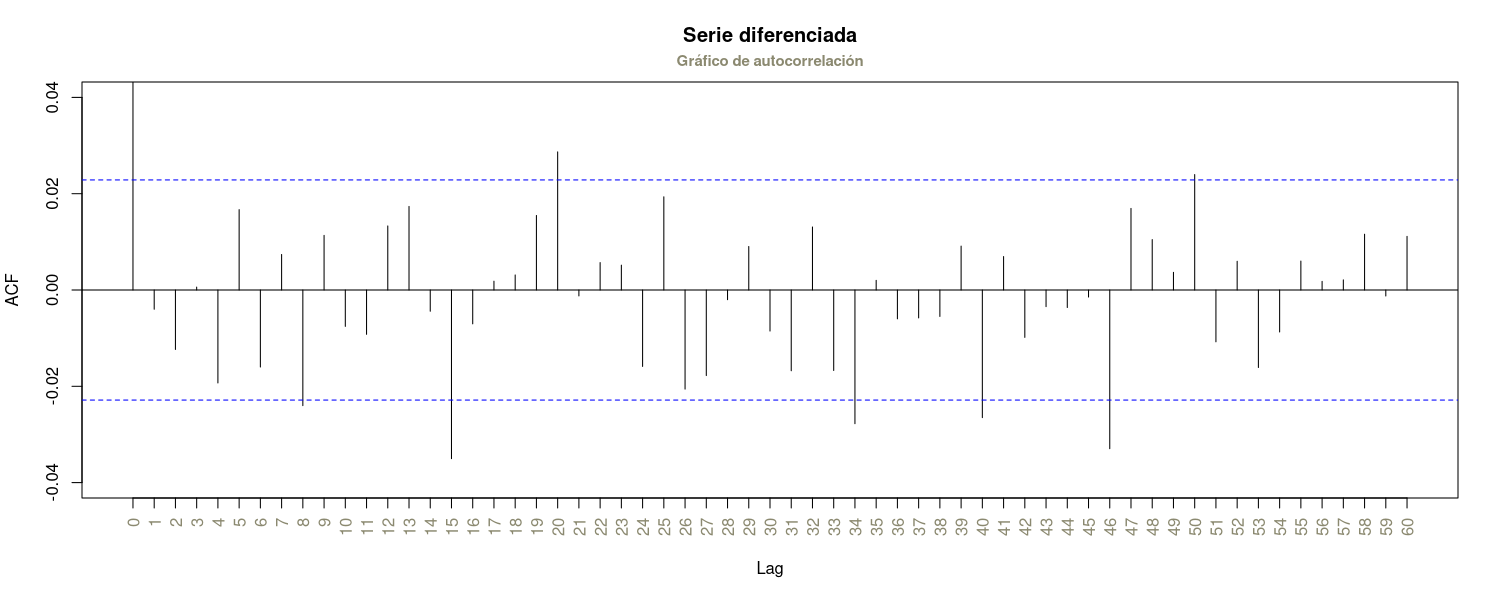

In [229]:
%%R -w 15 -h 6 --units in -r 100
corrOro = acf(SerieOro,lag.max = 60, main='Serie diferenciada', ylim = c(-0.04, 0.04), xaxt = 'n')
axis(side = 1, at = corrOro$lag, labels = 0:60, col.axis = "#8B8970", las = 2)
mtext(expression(bold('Gráfico de autocorrelación')), side = 3, cex = 0.9, line = 0.6, col = '#8B8970')

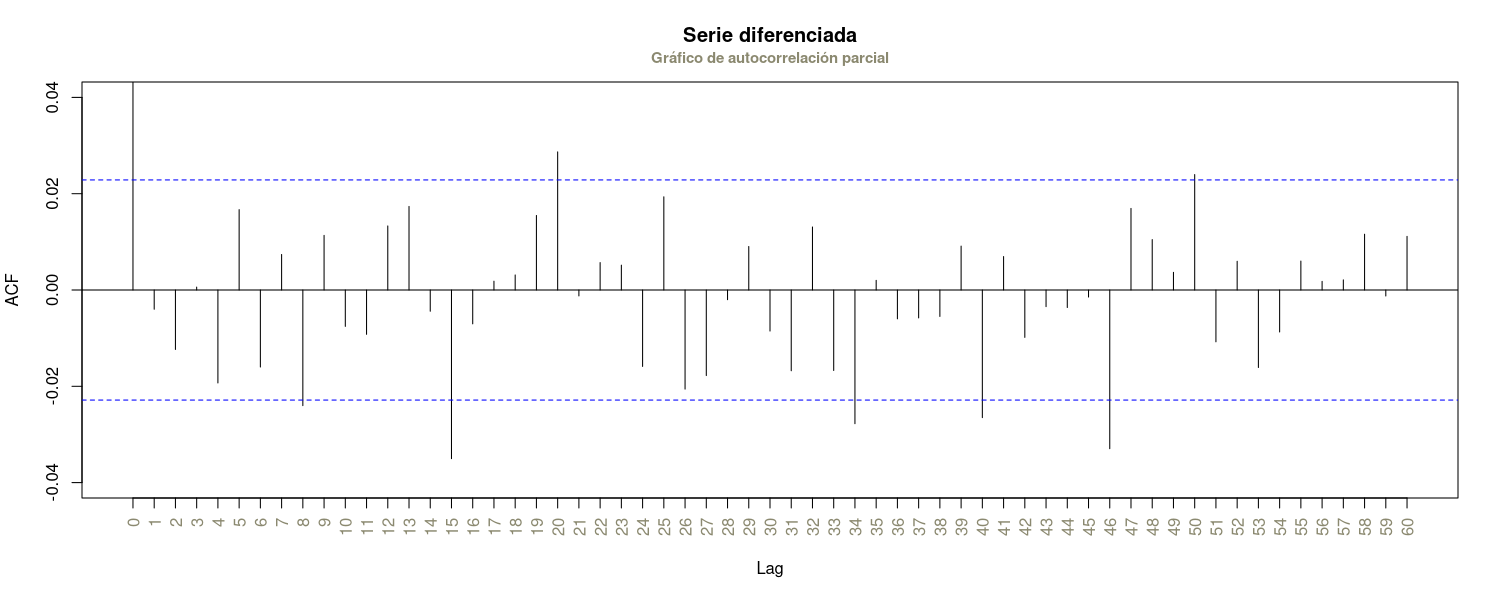

In [234]:
%%R -w 15 -h 6 --units in -r 100
acorrOro = acf(SerieOro,lag.max = 60, main='Serie diferenciada', ylim = c(-0.04, 0.04), xaxt = 'n')
axis(side = 1, at = acorrOro$lag, labels = 0:60, col.axis = "#8B8970", las = 2)
mtext(expression(bold('Gráfico de autocorrelación parcial')), side = 3, cex = 0.9, line = 0.6, col = '#8B8970')

### **Datos de entrenamiento, prueba y validación**

Esta serie sí tiene la cantidad suficiente de datos como para utilizar datos de entrenamiento, prueba y validación.

In [235]:
oro

,Valor
Fecha,
2004-01-02,-0.001902
2004-01-03,0.000000
2004-01-04,0.000000
2004-01-05,0.006033
2004-01-06,0.024586
...,...
2024-02-12,-0.009800
2024-02-13,-0.006865
2024-02-14,-0.006025
